In [7]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
def load_images_and_masks(image_dir, csv_path, target_size=(128, 128)):
    images = []
    masks = []
    csv_data = pd.read_csv(csv_path)

    for index, row in csv_data.iterrows():
        subject = str(row['subject']).strip()
        img_id = str(row['img']).strip()

        img_filename = f"{subject}_{img_id}.tif"
        mask_filename = f"{subject}_{img_id}_mask.tif"

        img_path = os.path.join(image_dir, img_filename)
        mask_path = os.path.join(image_dir, mask_filename)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
        else:
            print(f"Warning: Image not found at {img_path}")

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask = cv2.resize(mask, target_size)
            mask = (mask > 0).astype('float32')  # Ensure binary masks
            masks.append(mask)
        else:
            print(f"Warning: Mask not found at {mask_path}")

    images = np.array(images).astype('float32') / 255.0
    masks = np.array(masks).astype('float32')
    masks = np.expand_dims(masks, axis=-1)

    return images, masks

# Set paths
image_dir = "C:/Aishwarya/Courses/CIS 631 ML/Project/train"
csv_path = "C:/Aishwarya/Courses/CIS 631 ML/Project/train/_masks.csv"

# Load data
X, y = load_images_and_masks(image_dir, csv_path)
print(f"Images shape: {X.shape}")
print(f"Masks shape: {y.shape}")

# Step 2: Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")

# Step 3: Data augmentation
data_gen_args = dict(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

train_image_generator = image_datagen.flow(X_train, batch_size=8, seed=42)
train_mask_generator = mask_datagen.flow(y_train, batch_size=8, seed=42)

def combined_generator(image_generator, mask_generator):
    while True:
        images = next(image_generator)
        masks = next(mask_generator)
        yield images, masks

# Step 4: Define metrics
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

# Step 5: Combined Loss (Binary Crossentropy + Dice Loss)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Step 6: Build the CNN-based transfer learning model
def build_cnn_transfer_model(input_shape=(128, 128, 3)):
    # Load pre-trained VGG16 as the encoder
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze pre-trained weights

    inputs = layers.Input(shape=input_shape)

    # Encoder: Use VGG16 as feature extractor
    encoder_output = base_model(inputs)

    # Decoder: Upsample using Conv2D + UpSampling layers
    decoder = layers.UpSampling2D((2, 2))(encoder_output)
    decoder = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(decoder)

    # Final upsampling to match the target shape
    decoder = layers.UpSampling2D((2, 2))(decoder)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(decoder)

    # Compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_coefficient, iou])

    return model

# Build the model
cnn_transfer_model = build_cnn_transfer_model()
cnn_transfer_model.summary()

# Step 7: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_transfer_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = cnn_transfer_model.fit(
    combined_generator(train_image_generator, train_mask_generator),
    steps_per_epoch=len(X_train) // 8,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Step 8: Evaluate the model
val_loss, val_accuracy, val_dice, val_iou = cnn_transfer_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Dice Coefficient: {val_dice}")
print(f"Validation IoU: {val_iou}")


Images shape: (5635, 128, 128, 3)
Masks shape: (5635, 128, 128, 1)
Training data shape: (4508, 128, 128, 3), (4508, 128, 128, 1)
Validation data shape: (1127, 128, 128, 3), (1127, 128, 128, 1)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 128, 128, 1)         │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,281,921 (62.11 MB)

 Trainable params: 1,567,233 (5.98 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 2931s 5s/step - accuracy: 0.9663 - dice_coefficient: 0.1229 - iou: 0.0681 - loss: 0.9631 - val_accuracy: 0.9857 - val_dice_coefficient: 0.2115 - val_iou: 0.1191 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 2495s 4s/step - accuracy: 0.9738 - dice_coefficient: 0.2082 - iou: 0.1203 - loss: 0.8633 - val_accuracy: 0.9834 - val_dice_coefficient: 0.2878 - val_iou: 0.1696 - val_loss: 0.7723 - learning_rate: 0.0010
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 1707s 3s/step - accuracy: 0.9772 - dice_coefficient: 0.2604 - iou: 0.1554 - loss: 0.8082 - val_accuracy: 0.9823 - val_dice_coefficient: 0.3006 - val_iou: 0.1781 - val_loss: 0.7506 - learning_rate: 0.0010
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 2469s 4s/step - accuracy: 0.9778 - dice_coefficient: 0.2652 - iou: 0.1594 - loss: 0.8028 - val_accuracy: 0.9770 - val_dice_coefficient: 0.3292 - val_iou: 0.1983 - val_loss: 0.7374 - learning_rate: 0.0010
Epoch 5/20
563/563 ━━━━━

In [8]:
def preprocess_test_images(test_image_dir, target_size=(128, 128)):
    test_images = []
    for file_name in os.listdir(test_image_dir):
        img_path = os.path.join(test_image_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, target_size)
            test_images.append(img)
        else:
            print(f"Warning: Image not found at {img_path}")

    test_images = np.array(test_images).astype('float32') / 255.0
    return test_images

# Path to your test images directory
test_image_dir = "C:/Aishwarya/Courses/CIS 631 ML/Project/test"
X_test = preprocess_test_images(test_image_dir)
print(f"Test Images shape: {X_test.shape}")


Test Images shape: (5508, 128, 128, 3)


In [9]:
# Predict segmentation masks for the test images
predicted_masks = cnn_transfer_model.predict(X_test, batch_size=8)
print(f"Predicted Masks shape: {predicted_masks.shape}")


689/689 ━━━━━━━━━━━━━━━━━━━━ 981s 1s/step
Predicted Masks shape: (5508, 128, 128, 1)


In [10]:
# Apply a threshold to convert predicted probabilities to binary masks
threshold = 0.5
binary_masks = (predicted_masks > threshold).astype('uint8')
print(f"Binary Masks shape: {binary_masks.shape}")


Binary Masks shape: (5508, 128, 128, 1)


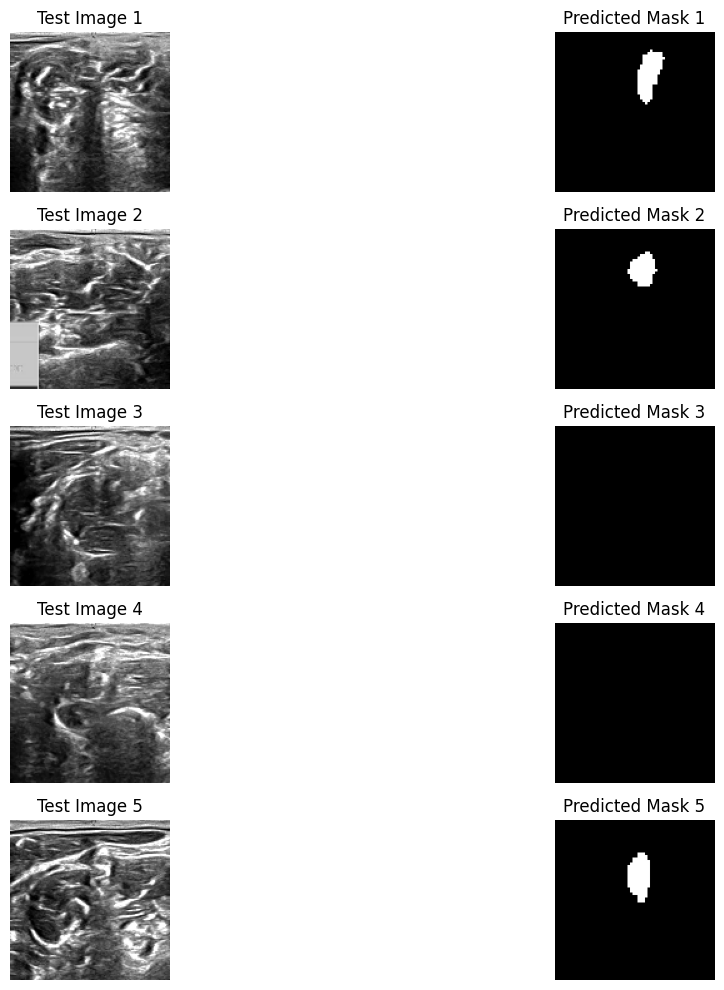

In [11]:
import matplotlib.pyplot as plt

def visualize_predictions(images, binary_masks, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(min(n, len(images))):
        # Test Image
        plt.subplot(n, 2, i * 2 + 1)
        plt.imshow(images[i])
        plt.title(f"Test Image {i+1}")
        plt.axis('off')

        # Predicted Binary Mask
        plt.subplot(n, 2, i * 2 + 2)
        plt.imshow(binary_masks[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize first 5 test images and their predicted masks
visualize_predictions(X_test, binary_masks, n=5)


In [12]:
import os

output_dir = "C:/Aishwarya/Courses/CIS 631 ML/Project/predicted_binary_masks"
os.makedirs(output_dir, exist_ok=True)

for i, mask in enumerate(binary_masks):
    mask_path = os.path.join(output_dir, f"binary_mask_{i+1}.png")
    cv2.imwrite(mask_path, (mask.squeeze() * 255).astype('uint8'))  # Scale to 0-255
print(f"Binary masks saved to {output_dir}")


Binary masks saved to C:/Aishwarya/Courses/CIS 631 ML/Project/predicted_binary_masks


In [14]:
def evaluate_test_set(model, X_test, y_test):
    results = model.evaluate(X_test, y_test)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]}")
    print(f"Test Dice Coefficient: {results[2]}")
    print(f"Test IoU: {results[3]}")

# If ground truth masks (y_test) are available
# evaluate_test_set(cnn_transfer_model, X_test, y_test)


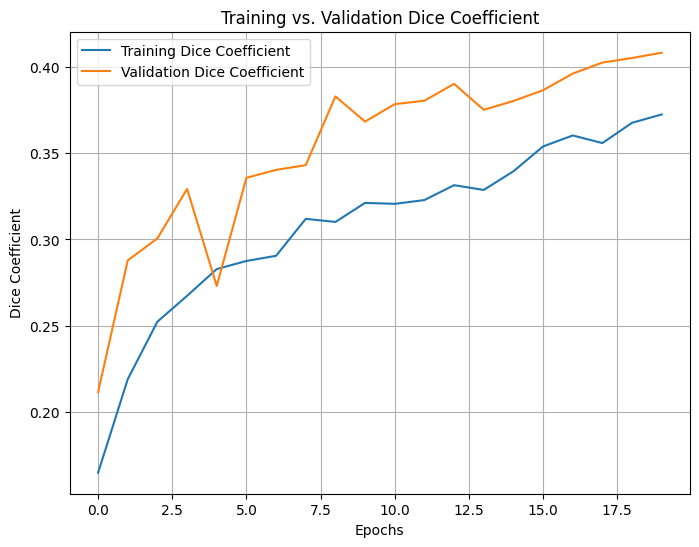

In [15]:
# Plot Dice Coefficient
def plot_dice_coefficient(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Training vs. Validation Dice Coefficient')
    plt.legend()
    plt.grid()
    plt.show()

plot_dice_coefficient(history)


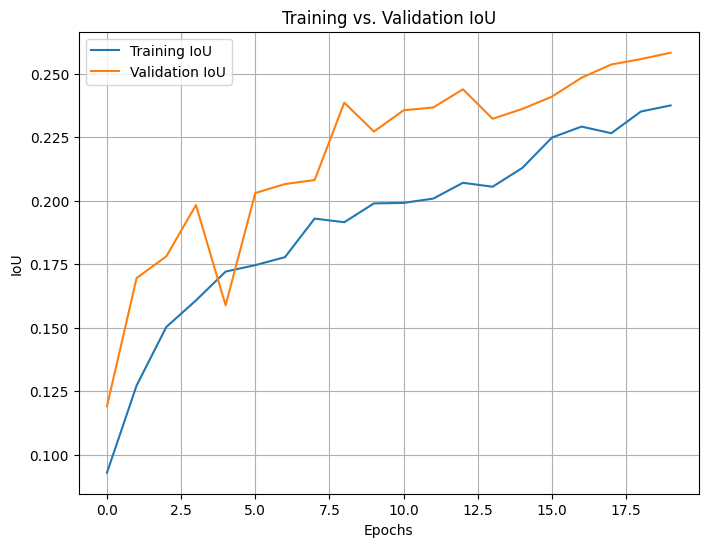

In [16]:
# Plot IoU
def plot_iou(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['iou'], label='Training IoU')
    plt.plot(history.history['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Training vs. Validation IoU')
    plt.legend()
    plt.grid()
    plt.show()

plot_iou(history)


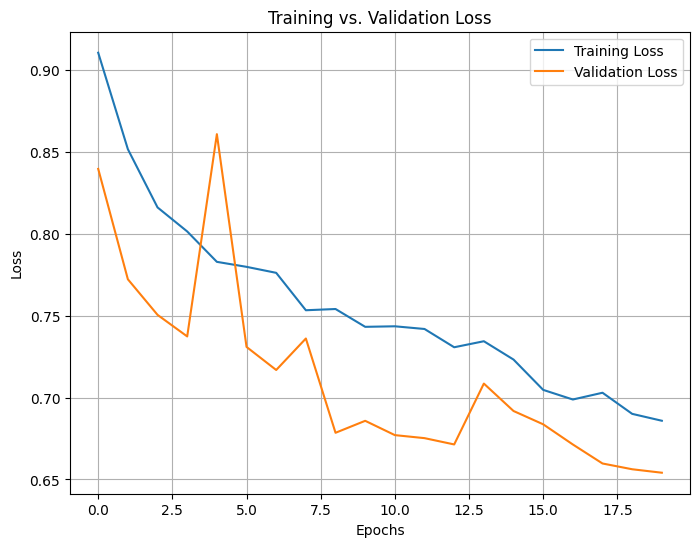

In [17]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)


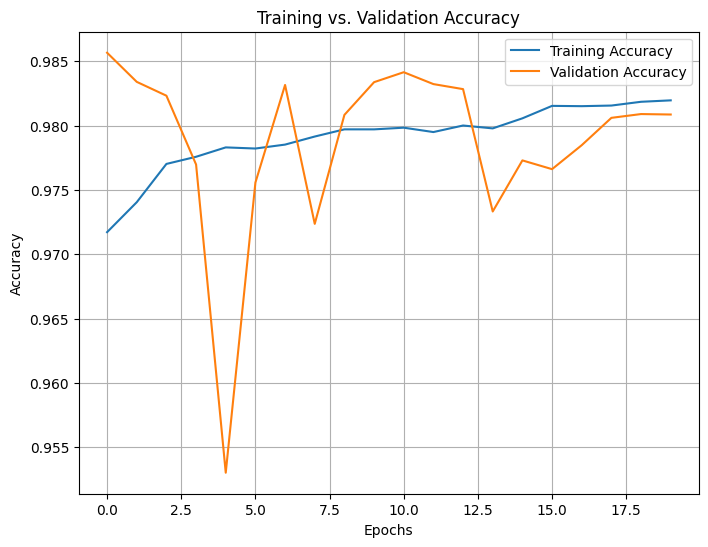

In [18]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy(history)


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Make predictions on the validation data
predicted_masks = cnn_transfer_model.predict(X_val)

# Binarize predicted masks to match the ground truth format
predicted_binary_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold the predicted values

# Flatten the arrays for metric calculation
y_val_flat = y_val.flatten()
predicted_flat = predicted_binary_masks.flatten()

# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_val_flat, predicted_flat)
recall = recall_score(y_val_flat, predicted_flat)
f1 = f1_score(y_val_flat, predicted_flat)

# Print the metrics
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step
Validation Precision: 0.3438
Validation Recall: 0.5634
Validation F1 Score: 0.4271
